# **Import**

In [284]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import imread
import os
import cv2
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

from tensorflow.keras.applications.vgg16 import VGG16
import visualkeras
from tensorflow.keras.applications.vgg16 import preprocess_input

from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve


In [ ]:
#pip install visualkeras


# **Dataset** **loading**

In [ ]:
base_dir = 'my_project/COVID-19-Lung-CT-Scans/'
pos_dir = 'drive/MyDrive/Colab Notebooks/covid_data/CT_COVID/'
neg_dir = 'drive/MyDrive/Colab Notebooks/covid_data/CT_NoneCOVID/'

In [ ]:
 #from google.colab import drive
 #drive.mount('/content/drive')

In [ ]:
img = os.path.join(  pos_dir, '2020.01.24.919183-p27-132.png')
df = cv2.imread(img)


In [ ]:
!pwd

/content


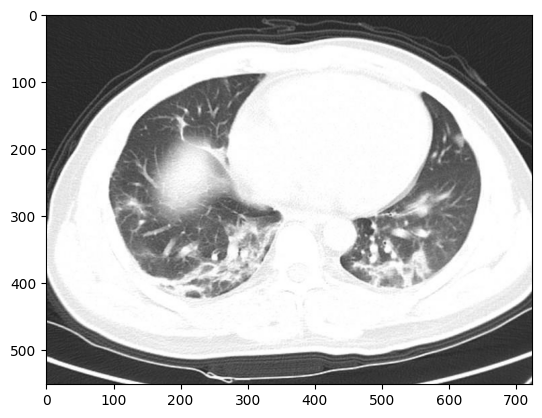

In [ ]:
plt.imshow(df, cmap='gray', vmin=0, vmax=1)
plt.show()

In [ ]:
print(f'Positive samples: {len(os.listdir(pos_dir))}.')
print(f'Negative samples: {len(os.listdir(neg_dir))}.')

Positive samples: 349.
Negative samples: 397.


In [ ]:
# Define image dimensions
img_width, img_height = 224, 224

# Function to load images from a folder
def load_images(folder):

    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        # Read the image
        img = cv2.imread(img_path)
        # Resize the image to the desired dimensions
        img = cv2.resize(img, (img_width,img_height))
        # Normalize the pixel values
        img = img/255
        #append img to the list
        images.append(img)
        if folder.endswith('CT_COVID/'): # if positive --> lable = 1 , if negative --> label = 0
          label = 1
        else:
          label = 0

        labels.append(label)
    return np.array(images), np.array(labels)


In [ ]:
# Load positive images
positive_images, positive_labels = load_images(pos_dir)

# Load negative images
negative_images, negative_labels = load_images(neg_dir)


In [ ]:
(positive_images.size, positive_labels.size)


(52534272, 349)

In [ ]:
(negative_images.size, negative_labels.size)

(59759616, 397)

In [96]:
# Concatenate positive and negative images and labels
all_images = np.concatenate([positive_images, negative_images], axis=0)
all_labels = np.concatenate([positive_labels, negative_labels], axis=0)

In [97]:
(all_images.size, all_labels.size)

(112293888, 746)

In [98]:
# Convert labels to one-hot encoding
#all_labels = to_categorical(all_labels, 2)

In [99]:
np.unique(all_labels)

array([0, 1])

# **Split Data**

In [213]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_images,
                                                    all_labels,
                                                    test_size=0.1,
                                                    random_state=42
                                                    )

# Print the shape of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (671, 224, 224, 3) (671,)
Testing set shape: (75, 224, 224, 3) (75,)


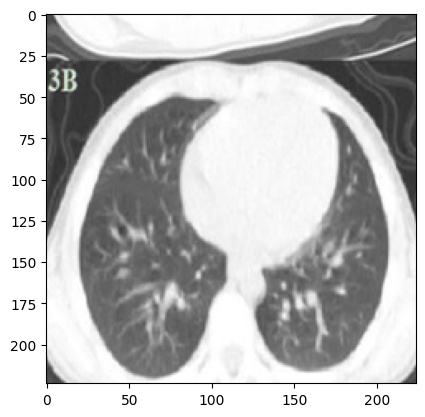

In [214]:
plt.imshow(X_train[9], cmap='gray', vmin=0, vmax=1)
plt.show()

In [215]:
# Considering only 1/10th of the 50_000 images
reduction_factor = 10

# Choosing the random indices of small train set and small test set
idx_train =  np.random.choice(len(X_train), round(len(X_train)/reduction_factor), replace=False)
idx_test =  np.random.choice(len(X_test), round(len(X_test)/reduction_factor), replace=False)

# Collecting the two subsamples images_train_small and images_test_small from images_train and images_test
X_train_small = X_train[idx_train]
X_test_small = X_test[idx_test]
# and their corresponding labels
y_train_small = y_train[idx_train]
y_test_small = y_test[idx_test]

print("------------------ Before -----------------")
print(X_train.shape, X_test.shape)

print("")

print("--- After applying the reduction factor ---")
print(X_train_small.shape, X_test_small.shape)

print("")
print("-"*43)

print("--- After applying the reduction factor ---")

unique, counts = np.unique(y_train_small, return_counts=True)
print(dict(zip(unique, counts)))
print("------------------ Before -----------------")

unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

------------------ Before -----------------
(671, 224, 224, 3) (75, 224, 224, 3)

--- After applying the reduction factor ---
(67, 224, 224, 3) (8, 224, 224, 3)

-------------------------------------------
--- After applying the reduction factor ---
{0: 29, 1: 38}
------------------ Before -----------------
{0: 359, 1: 312}


# **Model Initializing**

In [216]:
def initialize_model ():
    model = Sequential()

    model.add (layers.Conv2D(
        16,
        (1,1),
        activation = 'relu',
        padding = 'same',
        input_shape = (224,224,3)
        ))
    model.add(MaxPooling2D(2,2))
    #model.add (Dropout(0.2))

    model.add(Conv2D(
        32,
        (1, 1),
        activation = 'relu',
        padding = 'same'
        ))
    model.add(MaxPooling2D((2, 2)))
    #model.add(Dropout(0.2))

    model.add(Conv2D(
        64,
        (1, 1),
        activation = 'relu',
        padding = 'same'
        ))
    #model.add(Dropout(0.3))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(
        64,
        (1, 1),
        activation = 'relu',
        padding = 'same'
        ))
    model.add(Dropout(0.4))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(
        100,
        activation = 'relu'
        ))
    model.add(Dropout(0.4))
    model.add(Dense(
        1,
        activation = 'sigmoid'
        ))

    return model


In [217]:
def compile_model (model):
    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(
        loss = 'binary_crossentropy',
        optimizer = opt,
        metrics = ['accuracy', 'Precision', 'Recall']
    )
    return model


In [218]:
model = initialize_model ()
model.summary()
model = compile_model(model)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 224, 224, 16)      64        
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 112, 112, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 112, 112, 32)      544       
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 56, 56, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 56, 56, 64)        2112      
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 28, 28, 64)      

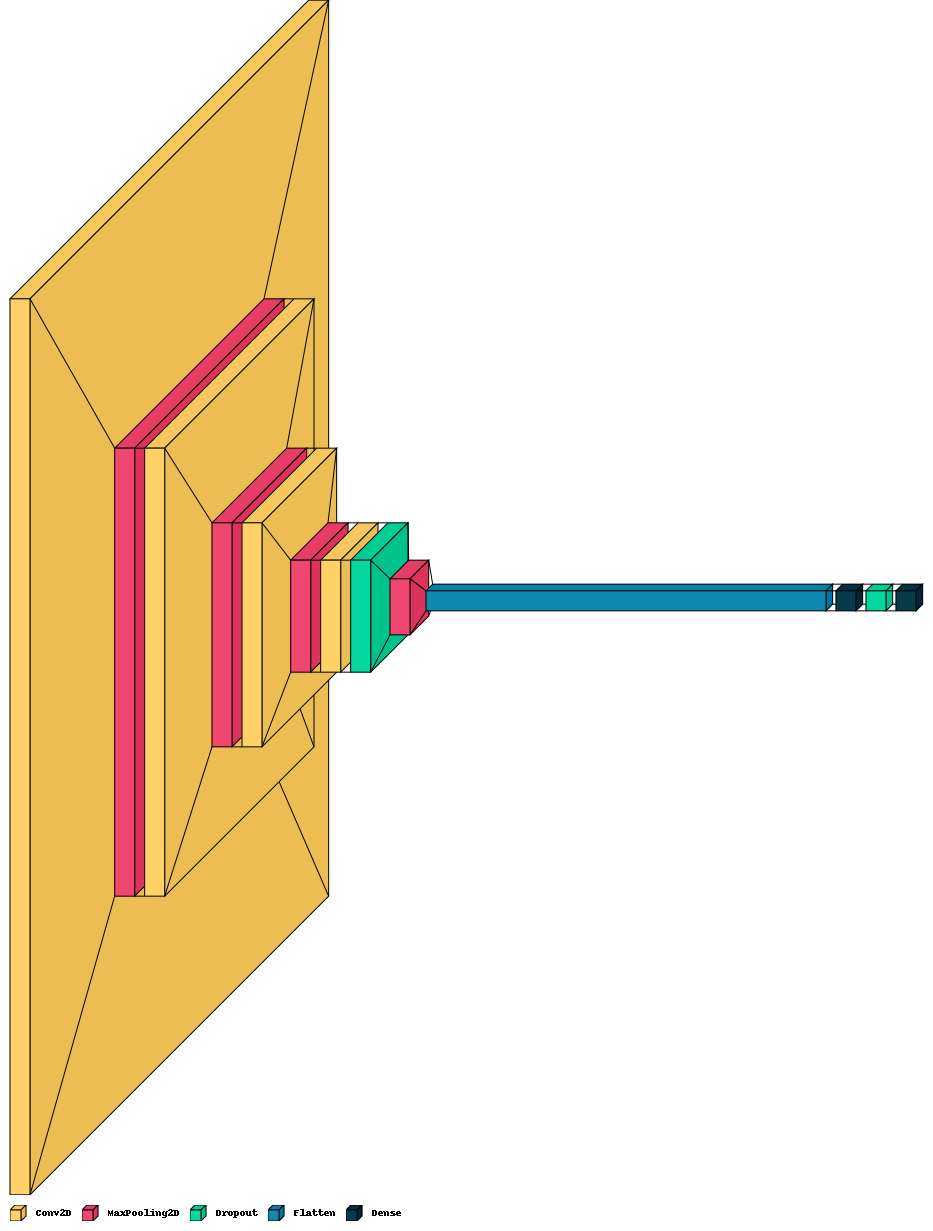

In [219]:

visualkeras.layered_view(model,legend = True)

In [220]:
es = EarlyStopping(
    patience = 5,
    restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    batch_size = 32,
    validation_split = .2,
    epochs = 500,
    verbose = 1,
    callbacks = [es]
    )

Epoch 1/500
17/17 [==============================] - 14s 743ms/step - loss: 0.6947 - accuracy: 0.5112 - precision: 0.4635 - recall: 0.3589 - val_loss: 0.6855 - val_accuracy: 0.5333 - val_precision: 0.5333 - val_recall: 0.1250
Epoch 2/500
17/17 [==============================] - 12s 733ms/step - loss: 0.6801 - accuracy: 0.5970 - precision: 0.5620 - recall: 0.5847 - val_loss: 0.6769 - val_accuracy: 0.5852 - val_precision: 0.6429 - val_recall: 0.2812
Epoch 3/500
17/17 [==============================] - 12s 670ms/step - loss: 0.6704 - accuracy: 0.5784 - precision: 0.5821 - recall: 0.3145 - val_loss: 0.6664 - val_accuracy: 0.6963 - val_precision: 0.6667 - val_recall: 0.7188
Epoch 4/500
17/17 [==============================] - 11s 649ms/step - loss: 0.6496 - accuracy: 0.6493 - precision: 0.6210 - recall: 0.6210 - val_loss: 0.6558 - val_accuracy: 0.6593 - val_precision: 0.6957 - val_recall: 0.5000
Epoch 5/500
17/17 [==============================] - 13s 763ms/step - loss: 0.6407 - accuracy: 0

# **Model Evaluation**

In [221]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 105ms/step - loss: 0.5702 - accuracy: 0.6800 - precision: 0.7097 - recall: 0.5946


[0.5702448487281799,
 0.6800000071525574,
 0.7096773982048035,
 0.5945945978164673]

In [222]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2, ax3, ax4 = axs
    else:
        f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 1)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()

    ax3.plot(history.history['recall'], label='train recall'  + exp_name)
    ax3.plot(history.history['val_recall'], label='val recall'  + exp_name)
    ax3.set_ylim(0, 1.)
    ax3.set_title('Recall')
    ax3.legend()

    ax4.plot(history.history['precision'], label='train precision'  + exp_name)
    ax4.plot(history.history['val_precision'], label='val precision'  + exp_name)
    ax4.set_ylim(0, 1.)
    ax4.set_title('Precision')
    ax4.legend()

    return (ax1, ax2, ax3, ax4)

(<Axes: title={'center': 'loss'}>,
 <Axes: title={'center': 'Accuracy'}>,
 <Axes: title={'center': 'Recall'}>,
 <Axes: title={'center': 'Precision'}>)

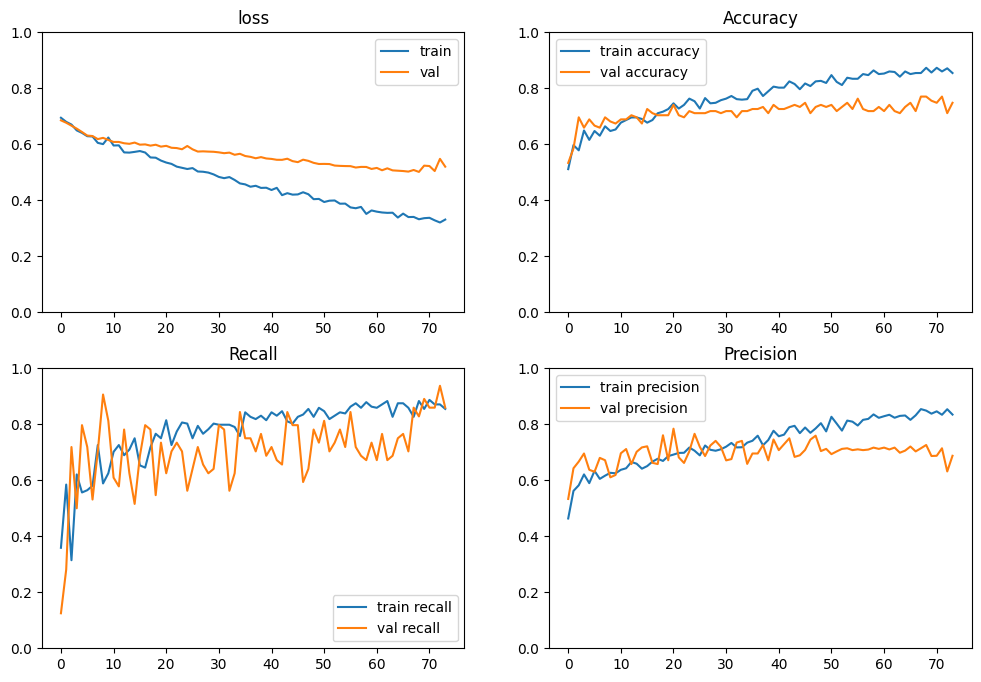

In [223]:
plot_history(history)

3/3 [==============================] - 0s 101ms/step


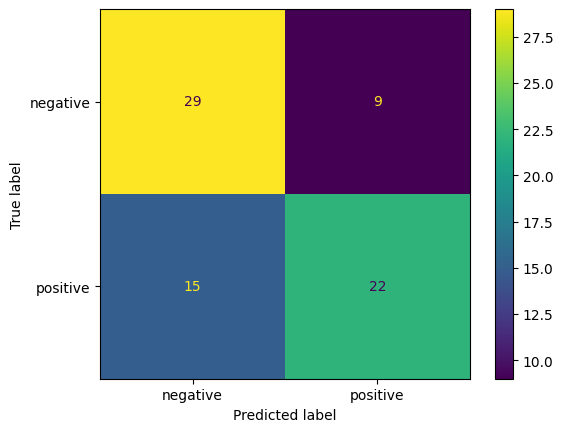

In [276]:

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Visualize confusion matrix
labels = ['negative', 'positive']  # set labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

In [275]:


print(classification_report(y_test,y_pred_classes))

              precision    recall  f1-score   support

           0       0.66      0.76      0.71        38
           1       0.71      0.59      0.65        37

    accuracy                           0.68        75
   macro avg       0.68      0.68      0.68        75
weighted avg       0.68      0.68      0.68        75



# **Update Threshold**

In [234]:

precision, recall, threshold = precision_recall_curve(y_test, y_pred)

In [235]:

scores = pd.DataFrame({'threshold':threshold,
                       'precision': precision[:-1],
                       'recall':recall[:-1]}) # Store in a dataframe
scores

,threshold,precision,recall
0,0.015283,0.493333,1.000000
1,0.034570,0.500000,1.000000
2,0.044007,0.506849,1.000000
3,0.045693,0.513889,1.000000
4,0.049116,0.521127,1.000000
...,...,...,...
70,0.829208,0.800000,0.108108
71,0.846338,0.750000,0.081081
72,0.854751,1.000000,0.081081
73,0.887036,1.000000,0.054054


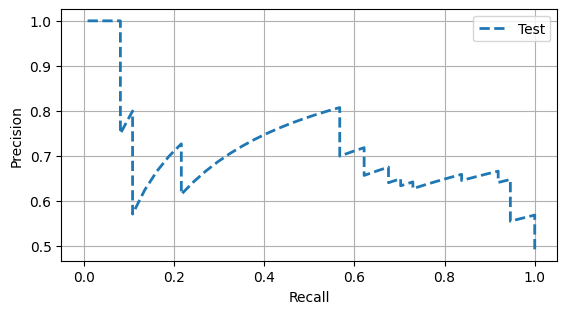

In [236]:
# plt.plot(scores['recall'],scores['precision'])
# plt.ylabel('precision')
# plt.xlabel('recall')

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)
    plt.plot(recall, precision, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_prc("Test", y_test, y_pred, linestyle='--')
plt.legend(loc='upper right')

In [238]:
custom_threshold = scores[scores['recall'] >= 0.9].threshold.max()

**We'll now update our threshold for our model using a custom prediction wrapper**

In [257]:

def custom_predict(X, custom_threshold):
    probs = model.predict(X) # Get likelihood of each sample being classified as 0 or 1
    #positive_probs = probs[:, 1] # Only keep positive likelihoods (1)
    return (probs > custom_threshold).astype(int) # Boolean outcome converted to 0 or 1


updated_preds = custom_predict(X=X_test, custom_threshold=custom_threshold) # Update predictions

print("Recall:", recall_score(y_test, updated_preds)) # Rerun recall
print("Precision:", precision_score(y_test, updated_preds)) # Rerun precision
print("F1 Score:", f1_score(y_test, updated_preds)) # Rerun f1

3/3 [==============================] - 1s 169ms/step
Recall: 0.8918918918918919
Precision: 0.66
F1 Score: 0.7586206896551725


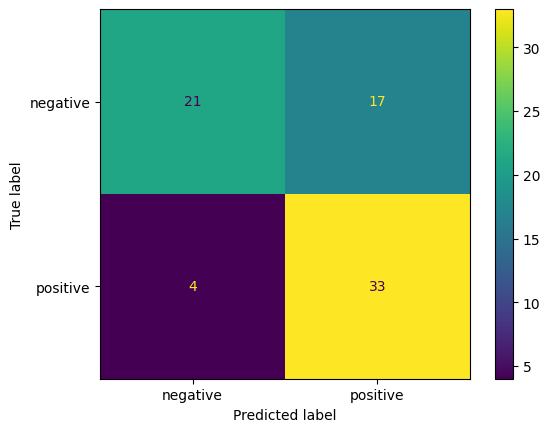

In [277]:

# Compute confusion matrix
cm_updated = confusion_matrix(y_test, updated_preds)

# Visualize confusion matrix
labels = ['negative', 'positive']  # set labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm_updated, display_labels=labels)
disp.plot()

In [279]:
print(classification_report(y_test,updated_preds))

              precision    recall  f1-score   support

           0       0.84      0.55      0.67        38
           1       0.66      0.89      0.76        37

    accuracy                           0.72        75
   macro avg       0.75      0.72      0.71        75
weighted avg       0.75      0.72      0.71        75

